In [1]:
import pandas as pd
import lzma
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = '../../sequence_data/detailed/profiles.csv.xz'
with lzma.open(file_path, 'rt') as file:
    signal_df = pd.read_csv(file)

seqs = tuple(signal_df.groupby('sequenceID'))
inputs = [torch.tensor(seq[1]['signal'].to_numpy(), dtype=torch.float32) for seq in seqs]

In [3]:
seq_IDs = [seq[0] for seq in seqs]
target_df = pd.read_csv(f'../../training_data/detailed/target.csv')
target_df = target_df[target_df['sequenceID'].isin(seq_IDs)]
output = torch.tensor(target_df.iloc[:, 1:].to_numpy())

In [4]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [5]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        lstm_out, _ = self.lstm(x)  # Forward pass through LSTM
        # Use the output of the last time step
        last_out = lstm_out[:, -1, :]  # Get the last output for each sequence
        x = self.fc(last_out)  # Fully connected layer
        return x

In [6]:
# Hyperparameters
input_size = 1              # Assuming the input feature size is 1
hidden_size = 32            # You can adjust this value
num_layers = 1              # Number of LSTM layers

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = SquaredHingeLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
# Initialize variables for best loss and best model
best_loss = float('inf')    # Set best_loss to infinity initially
patience_counter = 0        # Counter for early stopping
patience = 50               # Number of epochs to wait for improvement before stopping
best_model_state = None     # Variable to store the best model parameters

# Training loop
for epoch in range(10000):
    total_loss = 0
    for i, seq_input in enumerate(inputs):
        # Prepare input and target for the current sequence
        target = output[i].unsqueeze(0)  # Get the corresponding target for the sequence
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        seq_input = seq_input.unsqueeze(0).unsqueeze(-1)    # Shape: (1, seq_length, input_size)
        output_seq = model(seq_input)                       # Get model output for the sequence
        loss = criterion(output_seq, target.unsqueeze(-1))  # Calculate loss
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average loss for this epoch
    average_loss = total_loss / len(inputs)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}], Average Loss: {average_loss:.8f}')
    
    # Early stopping logic
    if average_loss < best_loss:
        best_loss = average_loss  # Update best loss
        patience_counter = 0  # Reset patience counter
        
        # Save the best model parameters in memory
        best_model_state = model.state_dict()  # Store the model parameters
    else:
        patience_counter += 1  # Increment patience counter
        
    # Stop training if patience is exceeded
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

# After training, you can restore the best model parameters if needed
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.eval()  # Set the model to evaluation mode

Epoch [0], Average Loss: 0.39677520
Epoch [10], Average Loss: 0.38884286
Epoch [20], Average Loss: 0.37749983
Epoch [30], Average Loss: 0.31285998
Epoch [40], Average Loss: 0.27745053
Epoch [50], Average Loss: 0.25055127
Epoch [60], Average Loss: 0.27062929
Epoch [70], Average Loss: 0.37871006
Epoch [80], Average Loss: 0.36583597
Epoch [90], Average Loss: 0.27512594
Epoch [100], Average Loss: 0.24744302
Epoch [110], Average Loss: 0.38758365
Epoch [120], Average Loss: 0.38362340
Epoch [130], Average Loss: 0.39223889
Epoch [140], Average Loss: 0.38448568
Epoch [150], Average Loss: 0.38212738
Early stopping triggered after 151 epochs.


In [8]:
# Function to test the model
def test_model(model, inputs):
    model.eval()  # Set the model to evaluation mode
    predictions = []  # List to store the predictions

    with torch.no_grad():  # Disable gradient calculation
        for seq_input in inputs:
            seq_input = seq_input.unsqueeze(0).unsqueeze(-1)  # Shape: (1, seq_length, input_size)
            output_seq = model(seq_input)  # Get model output for the sequence
            predictions.append(output_seq.item())  # Store the prediction

    return predictions

# Test the model and collect outputs
predicted_outputs = test_model(model, inputs)

In [9]:
# Function to extract last output from the model
def extract_last_output(model, inputs):
    model.eval()  # Set the model to evaluation mode
    last_outputs = []  # List to store last outputs

    with torch.no_grad():  # Disable gradient calculation
        for seq_input in inputs:
            seq_input = seq_input.unsqueeze(0).unsqueeze(-1)  # Shape: (1, seq_length, input_size)
            lstm_out, _ = model.lstm(seq_input)  # Forward pass to get LSTM outputs
            last_out = lstm_out[:, -1, :]  # Get the last output for the sequence
            last_outputs.append(last_out.squeeze().numpy())  # Store the last output as a NumPy array

    return np.array(last_outputs)  # Convert list to NumPy array

# Extract last outputs for each sequence in training data
last_outputs = extract_last_output(model, inputs)

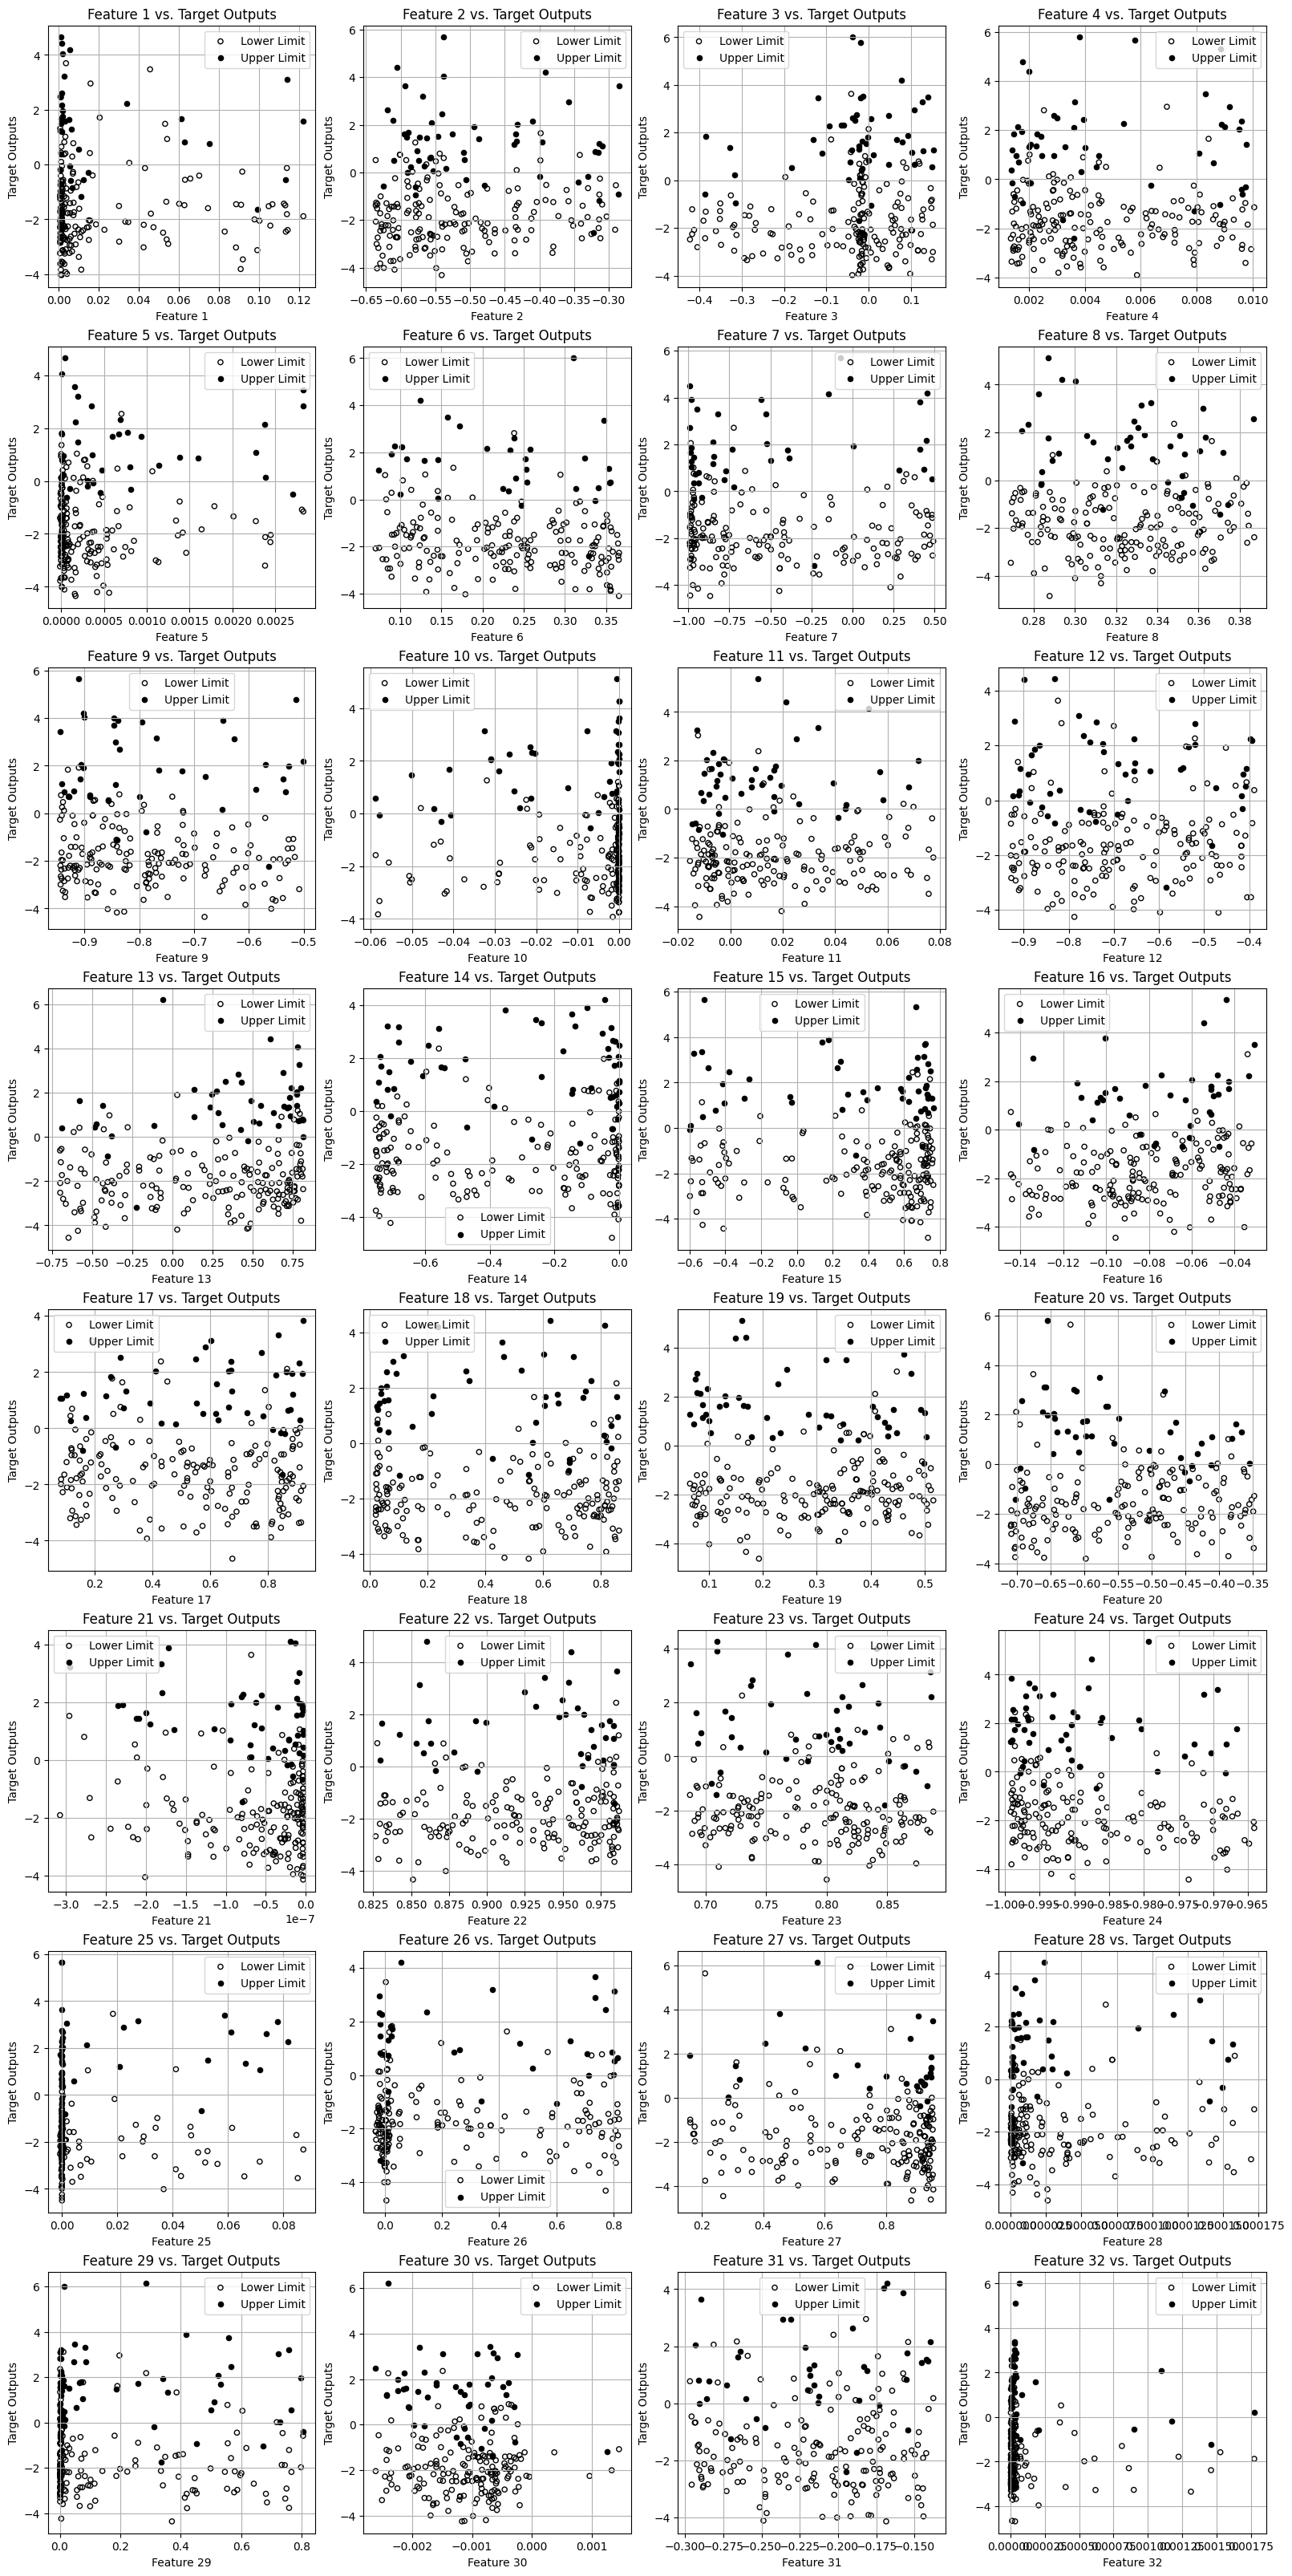

In [10]:
# Number of features to plot
num_features = last_outputs.shape[1]

# Calculate number of rows needed for 4 features per row
num_rows = (num_features + 3) // 4  # Ceiling division to determine number of rows

# Create a single figure with subplots
fig, axs = plt.subplots(num_rows, 4, figsize=(4 * 4, 4 * num_rows), constrained_layout=True)

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Total number of samples
total_samples = last_outputs.shape[0]

# Set the number of random points to sample
num_random_points = 200

# Ensure we do not exceed the number of available samples
num_random_points = min(num_random_points, total_samples)

# Iterate through each feature and plot
for i in range(num_features):
    # Extract feature from last_outputs
    feature = last_outputs[:, i]

    # Convert target outputs to NumPy arrays for plotting
    target_outputs_low = output.numpy()[:, 0]  # Lower target outputs
    target_outputs_up = output.numpy()[:, 1]    # Upper target outputs

    # Calculate the 25th and 75th percentiles of the feature
    q25 = np.percentile(feature, 25)
    q75 = np.percentile(feature, 75)

    # Filter the feature based on quartiles
    quartile_indices = (feature >= q25) & (feature <= q75)

    # Randomly select indices from the filtered data
    filtered_feature = feature[quartile_indices]
    filtered_target_outputs_low = target_outputs_low[quartile_indices]
    filtered_target_outputs_up = target_outputs_up[quartile_indices]

    # If there are more than 200 points in the filtered data, sample randomly
    if filtered_feature.shape[0] > num_random_points:
        random_indices = np.random.choice(filtered_feature.shape[0], size=num_random_points, replace=False)
        random_feature = filtered_feature[random_indices]
        random_target_outputs_low = filtered_target_outputs_low[random_indices]
        random_target_outputs_up = filtered_target_outputs_up[random_indices]
    else:
        random_feature = filtered_feature
        random_target_outputs_low = filtered_target_outputs_low
        random_target_outputs_up = filtered_target_outputs_up

    # Plot lower target outputs as hollow circles
    axs[i].scatter(random_feature, random_target_outputs_low, edgecolor='black', facecolor='none', label='Lower Limit', s=20, marker='o')
    
    # Plot upper target outputs as solid circles
    axs[i].scatter(random_feature, random_target_outputs_up, color='black', label='Upper Limit', s=20)

    # Adding titles and labels
    axs[i].set_title(f'Feature {i + 1} vs. Target Outputs')
    axs[i].set_xlabel(f'Feature {i + 1}')
    axs[i].set_ylabel('Target Outputs')
    axs[i].grid(True)
    axs[i].legend()

# Hide any empty subplots
for j in range(num_features, num_rows * 4):
    axs[j].axis('off')

# Show the plots
plt.show()

In [11]:
torch.save(model.state_dict(), f'model_{num_layers}_{hidden_size}.pth')